Моделируемое уравнение: $\dot{\phi}_j = \displaystyle\frac{\mu}{2} \Big[ \omega_j + \displaystyle\frac{d}{R_j}\sum_{k=1}^N{R_k(\sin(\phi_k-\phi_j-\gamma))} \Big], \quad j\neq k$


In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from numba import jit
from pprint import pprint
import networkx as nx

#np.set_printoptions(threshold=np.inf)

In [2]:
# Параметры системы
N = 128
mu = 0.1
d = 0.3
gamma = np.pi/4

'''
omega = np.ones(N)
R = np.ones((N, N))
np.fill_diagonal(R, 0)  
'''

omega = np.random.rand(N)
R = np.random.rand(N, N)
np.fill_diagonal(R, 0)      # значения на диагонали равны 0
R = 0.5 * (R + R.T)         # делаем матрицу R симметричной

In [3]:
print('omega:')
pprint(omega)
print('------------\n')

print('R:')
pprint(R)
print('------------\n')

omega:
array([0.28407319, 0.35476489, 0.39526219, 0.42373087, 0.57437163,
       0.95171377, 0.60161371, 0.48682076, 0.84026499, 0.14860739,
       0.96087414, 0.32257173, 0.0858921 , 0.31686464, 0.04970094,
       0.02621702, 0.39706499, 0.39215174, 0.28658116, 0.65636789,
       0.76095279, 0.40412643, 0.44381407, 0.22397547, 0.3425196 ,
       0.73314482, 0.54910745, 0.21182398, 0.11578101, 0.28744257,
       0.35332274, 0.45530368, 0.41463201, 0.85628881, 0.26789731,
       0.01902231, 0.26224375, 0.57040306, 0.52000979, 0.28381066,
       0.59236414, 0.69680552, 0.35628613, 0.12957185, 0.26207855,
       0.5291146 , 0.9460822 , 0.77252417, 0.94045075, 0.61094986,
       0.95422153, 0.88733968, 0.37975495, 0.77356609, 0.1102813 ,
       0.08554454, 0.94620873, 0.22818927, 0.57966279, 0.81936519,
       0.07513615, 0.60126045, 0.09579544, 0.21544285, 0.12932339,
       0.46219955, 0.49629966, 0.64631161, 0.76542252, 0.23034422,
       0.25972423, 0.99578207, 0.0914665 , 0.66900177, 

## Граф

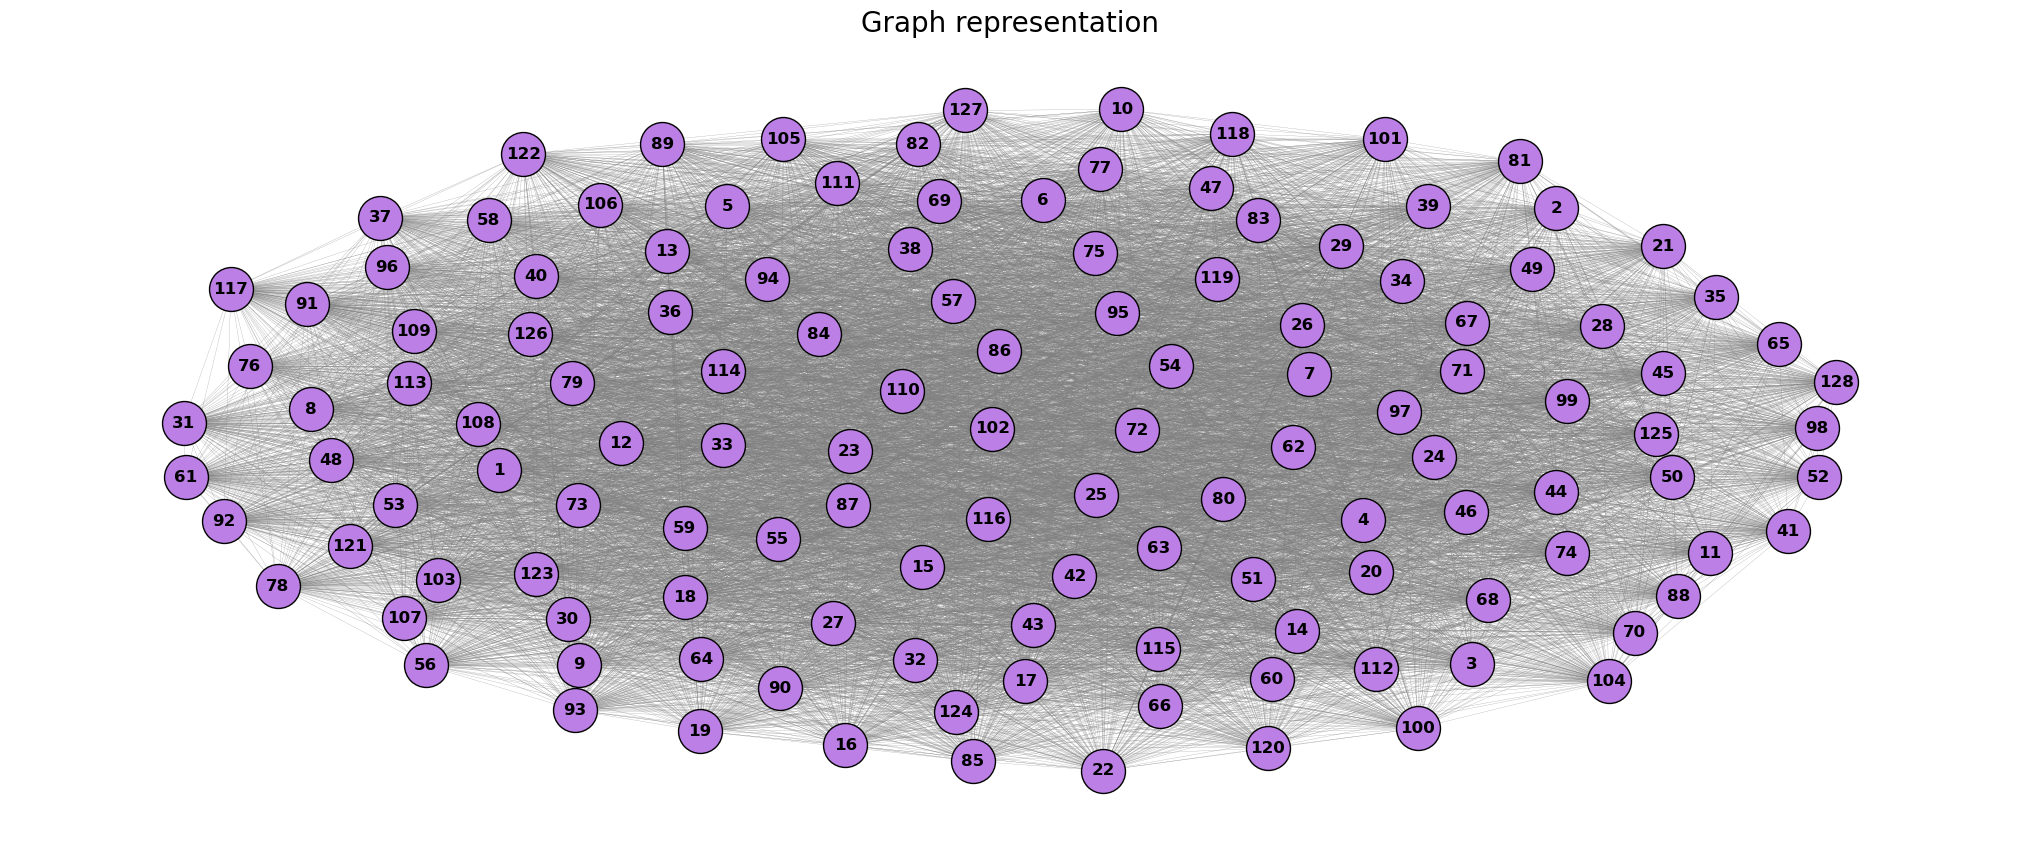

In [4]:
# Создание графа
G = nx.Graph()

# Добавление узлов в граф (начиная с 1)
for i in range(1, N + 1):
    G.add_node(i, label=f'Node {i}')

# Добавление рёбер в граф (используем теперь i и j с 1 по N)
for i in range(1, N + 1):
    for j in range(i + 1, N + 1):
        G.add_edge(i, j, weight=R[i-1, j-1])


# Отображение графа
pos = nx.spring_layout(G, k=0.9)
plt.figure(figsize=(20, 8))
nx.draw(G, pos, node_color='#bc7fe5', node_size=1_000, edge_color='grey', edgecolors='black', width=0.15, with_labels=True, font_weight='bold')

plt.title('Graph representation', size=20)
plt.show()

## Система

In [5]:
result = np.zeros(N)

@jit(nopython=True)
def system(phi, t, N, mu, omega, gamma, d, R):
    result = np.zeros(N)
   
    for j in range(N):
        summation = 0
        for k in range(N):
            if (R[j, k] != 0) and (j != k):      # первое - есть ли связь, второе - сами с собой осц не связаны
                summation += R[j, k] * np.sin(phi[k] - phi[j] - gamma)
        if j + 1 <= N - 1: 
            result[j] = mu / 2 * (omega[j] + d / R[j + 1, j] * summation)
        else: 
            if  R[0, j] != 0:   # будет 0 только когда связи произвольно заданы
                result[j] = mu / 2 * (omega[j] + d / R[0, j] * summation)
            else: result[j] = mu / 2 *omega[j]

    return result

phi0 =  np.arange(0, 2*np.pi, 2*np.pi/N)

t_span = np.linspace(0, 1000, 1000)

solution = odeint(system, phi0, t_span, args=(N, mu, omega, gamma, d, R))

solution = np.fmod(solution, 2*np.pi)               # приведение к [0, 2пи]
solution[solution == 2*np.pi] -= 2*np.pi            # 0 и 2пи на окружности одна точка
solution[solution < 0] += 2*np.pi                   # отрицательные привели к [0, 2пи]

pprint(solution)

array([[0.        , 0.04908739, 0.09817477, ..., 6.13592315, 6.18501054,
        6.23409792],
       [6.253135  , 0.00828637, 0.12545165, ..., 6.07963909, 6.18227006,
        6.26728697],
       [6.22188327, 6.25130559, 0.1454257 , ..., 6.02407067, 6.18402197,
        0.01257281],
       ...,
       [1.88218948, 5.41466294, 5.98502413, ..., 5.54766975, 5.10664868,
        1.26222916],
       [2.70030942, 4.3288324 , 4.91909314, ..., 4.46739668, 4.01092512,
        1.46987403],
       [2.91900614, 3.20120303, 3.82026946, ..., 3.34298571, 2.8957607 ,
        2.31527977]])


## Параметры порядка:

$R_1=\displaystyle \frac{1}{N}\Big|\sum^N_{j=2}e^{2i\pi\phi_j}\Big|$

$R_2=\displaystyle \frac{1}{N}\Big|\sum^N_{j=2}e^{4i\pi\phi_j}\Big|$

Final values of R1 and R2:
R1: 0.19068773955295845
R2: 0.10707102978576603


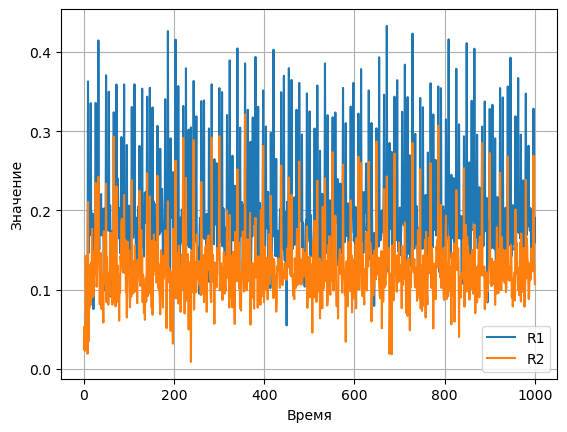

In [6]:
R1 = np.abs(np.mean(np.exp(2j * np.pi * solution[:, 1:]), axis=1) )
R2 = np.abs(np.mean(np.exp(4j * np.pi * solution[:, 1:]), axis=1) )

print("Final values of R1 and R2:")
print(f"R1: {R1[-1]}")
print(f"R2: {R2[-1]}")

# Построение графиков параметров порядка
plt.plot(t_span, R1, label='R1')
plt.plot(t_span, R2, label='R2')
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()


## Пространственно-временная диаграмма

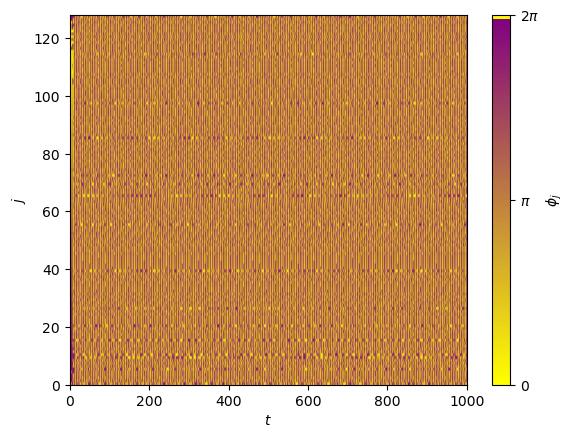

In [7]:
# Создание цветовой карты
colors = ['#FFFF00', '#800080']
n_bins = 100  # Количество оттенков

# 0 и 2*pi одним цветом
color_map_values = np.linspace([1, 1, 0], [128/255, 0, 128/255], n_bins)
color_map_values[0, :] = color_map_values[-1, :] = [1, 1, 0]

cmap_name = "custom_gradient"
custom_cmap = ListedColormap(color_map_values)

# Построение пространственно-временной диаграммы с градиентом цветовой карты
fig, ax = plt.subplots()
im = ax.imshow(solution.T, aspect='auto', cmap=custom_cmap, extent=[t_span[0], t_span[-1], 0, N], vmin=0, vmax=2*np.pi)
cb = plt.colorbar(im, ax=ax, label=fr'$\phi_j$', ticks=[0,np.pi,2*np.pi])
cb.set_ticklabels(['$0$', '$\pi$', '$2\pi$'])

plt.xlabel(fr'$t$')
plt.ylabel(fr'$j$')
plt.show()

## Распределение осцилляторов

final time

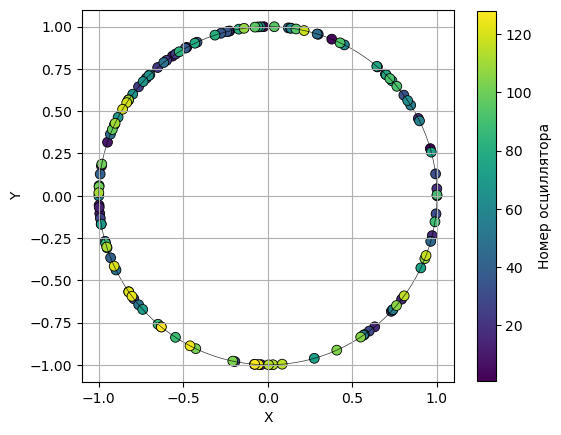

In [8]:
phi_diff = solution[-1, 1:] - solution[-1, 0]

theta = np.cumsum(np.concatenate(([0], phi_diff))) % (2 * np.pi)

x = np.cos(theta)
y = np.sin(theta)

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(x, y, c=range(1, N+1), cmap='viridis', s=50, edgecolor='black', linewidth=0.6)
ax.set_aspect('equal', 'box')

circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=0.5, alpha=0.8)
ax.add_patch(circle)
ax.grid()

cbar = plt.colorbar(sc, shrink=0.8)
cbar.set_label('Номер осциллятора')

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()